# Spatial Econometrics PySAL Workshop - Feb. 11, 2026
### Workshop by: Eli Knaap and Serge Rey
#### Notebook adapted from Luc Anselin's course material 

In this notebook, we cover a brief presentation of the main functionalities of the spreg library in PySAL. Spreg (short for spatial regression) supports the estimation of classic and spatial regression models. Currently, it contains methods for estimating standard and spatial versions of models such as Ordinary Least Squares (OLS), Two Stage Least Squares (2SLS), Seemingly Unrelated Regressions (SUR), and Random and Fixed effects panels. Additionally, it offers various tests of homoskedasticity, normality, spatial randomness, and different types of spatial autocorrelation.

# 1. Basic Data Management


This section covers some elementary functionality to carry out data input and output as well as some basic data manipulations. The key concept is a so-called *DataFrame*, a tabular representation of the data with observations as rows and variables as columns.

### Modules Needed

This is implemented by means of *pandas* for generic text files (as well as many other formats) and *geopandas* for spatial data files (shape files).

Before we can get to specific spatial functionality, we will be using *geopandas* to load data into so-called data frames. All of these rely on *numpy* as a dependency.

Pandas and numpy are installed by default if you used anaconda. Geopandas may not be installed. If that is the case, use:

`conda install -c conda-forge geopandas`

Note: if you use pip install, it may not work properly, see https://geopandas.org/en/v0.4.0/install.html

The full set of imports is shown below (note the special way to import geopandas due to some dependency issues - if you skip the os part, you may get a warning, but it still works).

The work horse for spatial analysis in Python is the *PySAL* library. In particular we will be using the utilities in *libpysal* (needs to be imported separately) for spatial weights.

It is good practice to check the version of libpysal and other PySAL modules to make sure the latest is being loaded.

Finally, the main module for spatial regression in PySAL is *spreg*. This is the module that will be the focus of this workshop. Due to time constraints, we will not be able to review all of its functionalities, but the core one should be covered here.

Should you want to check out *spreg*’s development, please visit https://github.com/pysal/spreg/


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
#import os
#os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import libpysal
print(libpysal.__version__)

import spreg
print(spreg.__version__)

### Files

We will be using data on socio-economic correlates of health outcomes contained in the **Chi-SDOH** sample data set. We will be using more than one file, make sure they are in the working directory (the code assumes they are there, otherwise, you will need to change the code and specify the full path):

- **Chi-SDOH.shp,shx,dbf,prj**: socio-economic indicators of health for 2014 in 791 Chicago tracts

All the files are defined here, so that it will be easy for you to re-run the commands for your own applications. The only changes needed would be the file names and/or variable names (if needed).

In [ ]:
folder = "data/Chicago-SDOH/"
infileshp = folder+"Chi-SDOH.shp"   # input shape file
outfileshp =  folder+"test.shp"    # output shape file

## Text Files

### Input

In Python, the easiest way to read shape files is to use *geopandas*. The command is `read_file`, followed by the file pathname in parentheses. The program is smart enough to figure out the file format from the file extension *.shp*. The result is a geopandas data frame, a so-called *GeoDataFrame*, say **dfs**, which is essentially a pandas data frame with an additional column for the geometry.

All the standard pandas commands also apply to a geopandas data frame, such as `shape`.

In the example, we use the **Chi-SDOH.shp** file as the input file, as specified in `infileshp` at the top of the notebook. 

In [ ]:
dfs = gpd.read_file(infileshp)
print(dfs.shape)
dfs.head()

### Descriptive Statistics

A quick summary of the data set is provided by the `describe` command.

In [ ]:
dfs.describe()

### Extracting Variables

Variables (columns) are extracted from a dataframe by listing their names in a list and subsetting the data frame. However, it is important to keep in mind that the result is a different view of the same data frame, which may not be what we want. In fact, in most applications, we will want the result to be a numpy array, so we need to make sure to cast the result as such.

For example, we will extract the variables **EP_AGE17**, **Ovr6514P** and **Pop2014** to compute a dependency ratio, i.e., the ratio of population under 18 and over 65 to the active population (between 18 and 65). We will then add the result to the data frame.

First, we put the variable names in a list to subset the data frame and check the type. Make sure to use double brackets, the argument to the subset [ ] is a list, so [[list]]. Note how the result is a data frame.

Note: if you want to do this for your own data set, possibly using different variables and different expressions, you will need to adjust the code below accordingly. Typically, this is avoided in these notebooks, but here there is no option to make things totally generic.

In [ ]:
df1 = dfs[['EP_AGE17','Ovr6514P','Pop2014']]
type(df1)

A more elegant approach and one that will make it much easier to reuse the code for different data sets and variables is to enter the variable names in a list first, and then pass that to subset the data frame.

In [ ]:
varnames = ['EP_AGE17','Ovr6514P','Pop2014','geometry']
df1 = dfs[varnames]
type(df1)

At this point, it is much more meaningful to get the descriptive statistics.

In [ ]:
df1.describe()

### Basic Choropleth Mapping

Geopandas contains some basic mapping functionality through the `plot` function. This is usually fine for rudimentary maps, but several other packages are available that contain greater functionality. For our purposes, the `plot` functionality is sufficient.

We start with a basic choropleth map of the **Pop2014** variable.

We need to specify the variable to be mapped, the size of the figure and a legend. Details are beyond the current scope, but the examples below provide some templates.

A preferred way of dealing with this is to export the spatial data frame to a new shape file and use that for further exploration in **GeoDa**.

In [ ]:
df1.plot('Pop2014', figsize=(6, 6),legend=True)

Not exactly the prettiest thing in the world. As usual, there are many options, too many to cover here. The most important ones are `cmap`, a colormap (defined in matplotlib) defined by a code, `scheme`, a map classification, and some arguments to the legend to fine tune its position. The latter are passed as a `legend_kws` dictionary. Here, standard quartiles are used, but for more fine tuned classifications, the the *mapclassify* module of PySAL should be imported.

To change the map from the default to a quartile map using an brownish color ramp and moving the legend to the right is illustrated below. Note that the ranking of the color ramp is the reverse from before, with lighter colors corresponding to lower dependency rates. Darker colors indicate more children and/or elderly.

For detailed information on the full range of options, see the docs.

In [ ]:
df1.plot('Pop2014',figsize = (6, 6), cmap='OrRd',scheme='quantiles',k=4,legend=True,
       legend_kwds={'loc':'center left','bbox_to_anchor':(1,0.5)})

### Writing a Shape File

As mentioned, a preferred approach is to export the spatial data frame and do the visualization in **GeoDa**.

The output is accomplished by the `to_file` command. This supports many different output formats, but the default is the ESRI shape file, so we do not have to specify any arguments other than the filename. Here, we use the output file name specified in `outfileshp`.

In [ ]:
df1.to_file(outfileshp)

## Practice

Use your own data set or one of the GeoDaCenter sample data sets to load a spatial data frame, create some new variables, optionally get descriptive statistics or map the data. We will be using this type of operation frequently in the course of the regression analysis, when we will add predicted values and/or residuals to a map.

# 2. Spatial Weights


This section covers a brief review of some basic operations pertaining to spatial weights: how to read them, construct them, and use them to create spatially lagged variables.

### Files and Variables

We will again be using data on socio-economic correlates of health outcomes contained in the **Chi_SDOH** sample shape files and associated spatial weights. The addition now are:

- **Chi-SDOH_q.gal**: queen contiguity spatial weights from `GeoDa`
- **Chi-SDOH_k6s.gal**: k-nearest neighbor weights for k=6, made symmetric in `GeoDa`

As before, we specify file names and variable names at the top of the notebook so that this is the only part that needs to be changed if you want to apply the code to your own data sets and variables.

In [ ]:
infileq = folder+"Chi-SDOH_q.gal"           # queen contiguity from GeoDa
infileknn = folder+"Chi-SDOH_k6s.gal"       # symmetric k-nearest neighbor weights from GeoDa

Output files.

In [ ]:
outfileq = folder+"test_q.gal"            # output file for queen weights computed with libpysal

To illustrate spatially lagged variables, we will use the variable **YPLL_rate**.

In [ ]:
y_name = ["YPLL_rate"]

## Spatial Weights from GeoDa

Spatial weights are an essential part of any spatial autocorrelation analysis or implementation of spatial regression. Functionality to create and analyze spatial weights is contained in the `libpysal` library.
The full range of functions is much beyond our scope and you are referred to the documentation and API for further details. Only the essentials are covered here, sufficient to proceed
with the spatial regression analysis.

Arguably the easiest way to create spatial weights is to use `GeoDa`, which
provides functionality to construct a wide range of contiguity as well as distance
based weights through a graphical user interface. The weights information is stored as **gal**, **gwt** or **kwt** files. We will consider this first.


### Queen Contiguity Weights

Contiguity weights can be read into PySAL spatial weights objects using the `read` function, after opening the file with `libpysal.io.open`. We apply this to the queen contiguity created by `GeoDa`, contained in **infileq**.

In [ ]:
wq = libpysal.io.open(infileq).read()
wq

The result is a PySAL spatial weights object of the class `libpysal.weights.weights.W`. In essence, this is a dictionary, with as keys `neighbors` and `weights`. Weights objects have several attributes, which can be accessed using the familiar dot notation. Some of the more important ones are illustrated below.

First, to illustrate the contents of the weights object, we consider the neighbors and weights for the first observation. 
These items are identical to the neighbors list for the first observation in the GAL file.

Remember that these are dictionaries, so you have to provide the proper *key* to access their elements. For example, for the first observations, this is **'1'** (with the quotes, hence a character) and not **0**, as an index.

In [ ]:
wq.neighbors['1']

In [ ]:
#wq.neighbors[0]

More explicitly, the object **wq.neighbors** is a dictionary. Its *keys* can be extracted by means of `wq.neighbors.keys()`. However, this will give all 791 values. In order to get a shorter list, we first turn the keys into a `list` and then `print` just the first five elements. It's always a good idea to check this if you are unsure of the values of the keys.

In [ ]:
print(list(wq.neighbors.keys())[0:5])

The weights associated with each observation key are found using `weights`.

In [ ]:
wq.weights['1']

A quick check on the number of observations, i.e., the number of rows in the weights matrix.

In [ ]:
wq.n

Minimum, maximum and average number of neighbors.

In [ ]:
wq.min_neighbors,wq.max_neighbors,wq.mean_neighbors

Percent non-zero neighbors (sparseness).

In [ ]:
wq.pct_nonzero

There is no explicit check for symmetry as such, but instead the lack of symmetry can be assessed by means of the `asymmetry` method, or the list of id pairs with asymmetric weights is obtained by means of the `asymmetries` attribute.

In [ ]:
wq.asymmetry()

In [ ]:
wq.asymmetries

Since contiguity weights are symmetric by construction, the presence of an asymmetry would indicate some kind of error. This is not the case in our example.

### K-Nearest Neighbors Weights

Similarly, we can read in the symmetric knn weights (k=6) created by `GeoDa` from the file **infileknn**:

In [ ]:
wk6s = libpysal.io.open(infileknn).read()
wk6s

Some characteristics:

In [ ]:
wk6s.n

In [ ]:
wk6s.min_neighbors,wk6s.max_neighbors,wk6s.mean_neighbors

Note how the operation to make the initially asymmetric k-nearest neighbor weights symmetric has resulted in many observations having more than 6 neighbors. That is the price to pay to end up with symmetric weights, which is required for some of the estimation methods. We can list neighbors and weights in the usual way. As it turns out, the observation with key `1` is not adjusted, but observation with key `3` now has eight neighbors.


In [ ]:
wk6s.neighbors['1']

In [ ]:
wk6s.neighbors['3']

## Weights from a GeoDataFrame

### Queen Contiguity Weights

The weights construction is handled by the `libpysal` package in PySAL. The function is `weights.Queen.from_dataframe` with as arguments the geodataframe and optionally the `ids` (recommended). For the Chicago data, the ID variable is **OJECTID**. That is why we made sure it was turned into an integer first.


In [ ]:
wq1 = libpysal.weights.Queen.from_dataframe(dfs,ids='OBJECTID')
wq1

A quick check on the keys reveals these are indeed integers.

In [ ]:
print(list(wq1.neighbors.keys())[0:5])

Again, some characteristics:


In [ ]:
wq1.n

In [ ]:
wq1.min_neighbors,wq1.max_neighbors,wq1.mean_neighbors

The structure of the weights is identical to that from the file read from `GeoDa`. For example, the first set of neighbors is:


In [ ]:
wq1.neighbors[1]

With associated weights.

In [ ]:
wq1.weights[1]

### Row-standardization

As created, the weights are simply 1.0 for binary weights. To turn the weights into row-standardized form, a *transformation* is needed, `wq1.transform = 'r'`:


In [ ]:
wq1.transform = 'r'
wq1.weights[1]

### Writing a Weights File

To write out the weights object to a GAL file, we have to use `libpysal.io.open`, however this time with the `write` method. The argument to the `open` command is the filename and `mode='w'` (for writing a file). The weights object itself is the argument to the `write` method.

Note that even though the weights are row-standardized, this information is lost in the output file.

In [ ]:
libpysal.io.open(outfileq,mode='w').write(wq1)

A quick check using the `weights.Queen.from_file` operation on the just created weights file.

We also check the dimension and the keys.

In [ ]:
wq1a = libpysal.weights.Queen.from_file(outfileq)
print(wq1a.n)
print(list(wq1a.neighbors.keys())[0:5])

Note how the type of the key has changed from integer above to character after reading from the outside file. This again stresses the importance of checking the keys before any further operations.

The weights are back to their original binary form.

In [ ]:
wq1a.weights['1']

### KNN Weights

The corresponding functionality for k-nearest neighbor weights is `weights.KNN.from_dataframe`. An important argument is `k`, the number of neighbors, with the default set to `2`, which is typically not that useful. Again, we include OBJECTID as the ID variable. Initially the weights are in binary form and we carry out a row-standardization.


In [ ]:
wk6 = libpysal.weights.KNN.from_dataframe(dfs,k=6,ids='OBJECTID')
wk6

In [ ]:
wk6.n

A quick check on the keys.

In [ ]:
print(list(wk6.neighbors.keys())[0:5])

We can check the neighbors of observation 3. This is a subset of six from the list of eight from the above symmetric knn weights.

In [ ]:
wk6.neighbors[3]

The k-nearest neighbor weights are intrinsically asymmetric. Rather than listing all the pairs that contain such asymmetries, we can check on the length of this list using the `asymmetry` method.

In [ ]:
print(len(wk6.asymmetry()))

KNN weights have a built-in method to make them symmetric: `symmetrize`

In [ ]:
wk6s2 = wk6.symmetrize()
print(len(wk6.asymmetry()))
print(len(wk6s2.asymmetry()))

The entries are now the same as for the symmetric knn GAL file that was read in from `GeoDa`. For example, the neighbors of observation with key `3` are:

In [ ]:
wk6s2.neighbors[3]

Finally, to make them row-standardized, we carry out the transformation again.

In [ ]:
wk6s2.transform = 'r'
wk6s2.weights[3]

## Practice

Experiment with various spatial weights for your own data set or for one of the GeoDa sample data sets. 

# 3. Ordinary Least Squares (OLS)

This section covers a brief review of the basic OLS regression and elementary regression diagnostics. In addition, we introduce Moran's I as a first test for spatial autocorrelation.

We will illustrate the various regression models in the context of the *immigrant paradox* and use
four variables from the SDOH data set: **YPLL_rate** (an index measuring premature mortality, i.e., higher values are worse health outcomes), **HIS_ct** (economic hardship index), **Blk14P** (percent Black population), and **Hisp14P** 
(percent Hispanic population).

We first create lists with the variable names for the dependent variable (y_name), the explanatory variables (x_names1 and x_names2), the data set (optional, as ds_name), and the weights (optional, as w_name). Note that the dependent variable needs to be a string, not a list with one element. On the other hand, the ds_name and w_name can be either a string or a list with one string element.

In [ ]:
y_name = 'YPLL_rate'
x_names1 = ['Blk14P','Hisp14P']
x_names2 = ['Blk14P','Hisp14P','HIS_ct']
ds_name = 'Chi-SDOH'
w_name = 'Chi-SDOH_q'

#### Setting up the variables:
*spreg* will automatically identify single dimension arrays and convert them to two dimensions with a single column. But it is always a good practice to work with correct dimention arrays, as we do with the y vector in this example.

Note that we do not include a constant term in the x matrices. This is included by default in the `spreg.OLS` routine.

In [ ]:
y = dfs[y_name].values
y.shape

In [ ]:
y = dfs[y_name].values.reshape(-1,1)
y.shape

In [ ]:
x1 = dfs[x_names1].values
x1.shape

In [ ]:
x2 = dfs[x_names2].values
x2.shape

## OLS Regression

We start with the simplest of OLS regressions where only y and X are specified as arguments in the `spreg.OLS` command.

The resulting OLS object has many attributes (see the docs for full details). An easy (the easiest) way to list the results is to print the `summary` attribute.

First, the regression with the two ethnicity explanatory variables. We set the option `nonspat_diag=False`, since the default will give us the diagnostics, to which we return below.

In [ ]:
ols1 = spreg.OLS(y, x1, nonspat_diag=False)

The basic result of this operation is to create an OLS object. We can see the range of attributes and methods this includes by means of the `dir` command.

In [ ]:
print(dir(ols1))

Arguably, the most useful of these is the `summary` method, which provides a nice looking output listing.

In [ ]:
print(ols1.summary)

As is, the output does not list any variable names or other information on the data set. In order to have a more informative output, `name_y`, `name_x` and `name_ds` should be specified in the arguments, as illustrated below.

In [ ]:
ols1a = spreg.OLS(y, x1, nonspat_diag=False,
                  name_y=y_name, name_x=x_names1, name_ds=ds_name)
print(ols1a.summary)

This bare bones regression output lists the variables and data set involved, and, in addition to the coefficient estimates, standard errors, t-statistics and p-values, includes the $R^2$ and adjusted $R^2$ as measures of fit. The mean and standard deviation of the dependent variable are given as well. These values are the same as computed in the previous notebook.

The overall fit of about 0.60 is reasonable and both slope coefficients are positive and highly significant. However, this result is somewhat misleading, which is revealed when the economic hardship variable is included.

In [ ]:
ols2 = spreg.OLS(y, x2, nonspat_diag=False,
                 name_y=y_name,name_x=x_names2,name_ds=ds_name)
print(ols2.summary)

The inclusion of economic hardship turned the coefficient of the Hispanic share from positive to
negative. This is the so-called *immigrant paradox*. All coefficients are highly significant, with an adjusted $R^2$ of 0.6316.

### Predicted Values and Residuals

Two important attributes of the regression object are the predicted values and residuals. Unlike many of the other attributes, these are full-length column vectors of size n x 1. They can be extracted as the `predy` and `u` attributes. 

The most useful application of the predicted values and residuals in a diagnostic sense is to plot and map them.

In [ ]:
preds = pd.DataFrame(np.hstack((ols2.predy,ols2.u)),columns=['ypred','resid'])
preds.head()

In [ ]:
pd.concat([dfs,preds],axis=1).plot('resid', figsize=(6, 6),cmap='OrRd',scheme='quantiles',k=4,legend=True,
       legend_kwds={'loc':'center left','bbox_to_anchor':(1,0.5)})

## Non-Spatial Diagnostics

The default setting for OLS regression is to always include the non-spatial diagnostics, with `nonspat_diag=True`. Since this is the default, this argument does not have to be set. We repeat the second regression with the default setting.

In [ ]:
ols2a = spreg.OLS(y,x2,
                 name_y=y_name,name_x=x_names2,name_ds=ds_name)
print(ols2a.summary)

The previous output is now agumented with several additional measures of fit (listed above the coefficients) as well as diagnostics for multicollinearity, non-normality and heteroskedasticity (listed below the coefficients).

The measures of fit on the left-hand column are all related to the sum of squared residuals. This is listed, as well as two measures of $\sigma^2$ (one from division by the degrees of freedom, the other - ML - from division by the number of observations) and their square roots, the S.E. of regression.

On the right-hand side are the results of an F-statistic for the joint significance of the coefficients and its associated p-value, the log-likelihood (under the assumption of normality) for use in comparisions with spatial models, and two adjustments of the log-likelihood for the number of variables in the model, the AIC and SC. Whereas a better fit is reflected in a higher log-likelihood, it is the reverse for AIC and SC (lower is better).

Below the listing of coefficients are the multicollinearity condition number, the Jarque-Bera test on normality of the errors and two tests for heteroskedasticity (random coefficients): the Breusch-Pagan LM test and the more robust (against non-normality) Koenker-Bassett test.

There is no evidence of a problem with multicollinearity, but a strong indication of both non-normality and heteroskedasticity.

### White test

Because it requires additional computation, the White test against heteroskedasticity is not included by default. To include it, the argument `white_test=True` must be set.

All the output is the same as before, except for the addition of the test results, which again strongly indicate the presence of heteroskedasticity.

In [ ]:
ols2b = spreg.OLS(y,x2,white_test=True,
                 name_y=y_name,name_x=x_names2,name_ds=ds_name)
print(ols2b.summary)

## Spatial Diagnostics

Moran's I is a very powerful misspecification test. While designed to detect spatial error autocorrelation, it also has power against a range of other misspecifications, including heteroskedasticity and non-normality. Hence, when the null is *not* rejected, one can be fairly confident that none of these misspecifications are present. On the other hand, when the null is rejected, it is not always clear what the next step should be, other than maybe implement HAC standard errors. More focused tests against spatial autocorrelation are considered in the notebook that deals with Maximum Likelihood estimation.

Moran's I test is invoked by setting the argument `moran=True`. However, this only works when `spat_diag=True`, which also gives all the other diagnostics for spatial dependence. At this point, we will ignored those. Without `spat_diag=True`, the standard output is obtained, without any diagnostics for spatial effects.

Of course, in order to get spatial diagnostics, a spatial weights object `w` must be specified, with its name optionally as `name_w`.

In [ ]:
ols5 = spreg.OLS(y,x2,spat_diag=True,moran=True,
                 w=wq1,name_w=w_name,
                 name_y=y_name,name_x=x_names2,name_ds=ds_name)
print(ols5.summary)

The output is again the same as before, with the addition of Moran's I as the first item under the heading *Diagnostics for Spatial Dependence*. The statistic is 0.0483, with a matching z-value of 2.619, which is significant at 1% level, showing evidence of spatial effects.

However, the Moran's I is not very informative as to what to do from here. Given the results for the spatial diagnostics, which spatial regression model should be considered as the alternative? Common diagnostics to assess the presence of spatial dependence include a collection of Lagrange Multiplier test statistics.

Historically, a forward specification search based on the LM statistics from an OLS regression was preferred in order to avoid the computational complexities associated with estimating the spatial models. This is not really an issue anymore, especially with the IV/GMM methodology and a backward specification search is a viable alternative.

Also, the use of the asymptotic t-test instead of the LM tests is a viable alternative.

The rationale behind the forward specification search is simple:

- step 1: assess the significance of the LM tests
  - if one is significant, this is the alternative model
  - if both are significant go to step 2
- step 2: assess the significance of the robust LM tests
  - if one is significant, this is the alternative model
  - if both are significant, go with the one with the highest value
  - if neither is significant, go with the one with the highest value
  
In any case, once the spatial model is estimated, the asymptotic t-tests are available as a further check on the validity of the model.

The forward specification decision rule is depicted in Figure 5.1 (p. 110) of Anselin and Rey (2004) (borrowed from Anselin, 2005).

From our test results, we see that Lagrange Multiplier (lag) statistic is significant at 1% level, hence rejecting the null hypothesis of a standard linear regression specification with spatial randomness in favor of a spatial lag specification. However, the Lagrange Multiplier (error) statistic is also significant at 1% level, suggesting a spatial error specification. Since both statistics reject their null, we need to consider their robust versions. 

It is important to keep in mind that the robust Lagrange Multiplier statistics should only be considered when both LM (lag) and LM (error) reject the null, but never when one of these statistics (or both) does not reject the null.

In this example, neither Robust LM (lag) or Robust LM (error) statistics are significant at 5%. In cases where both robust test statistics may still be signiﬁcant, the preferred alternative would be the one with the highest value for the statistic. Alternatively, we can test both specifications and choose the one with best model fit.

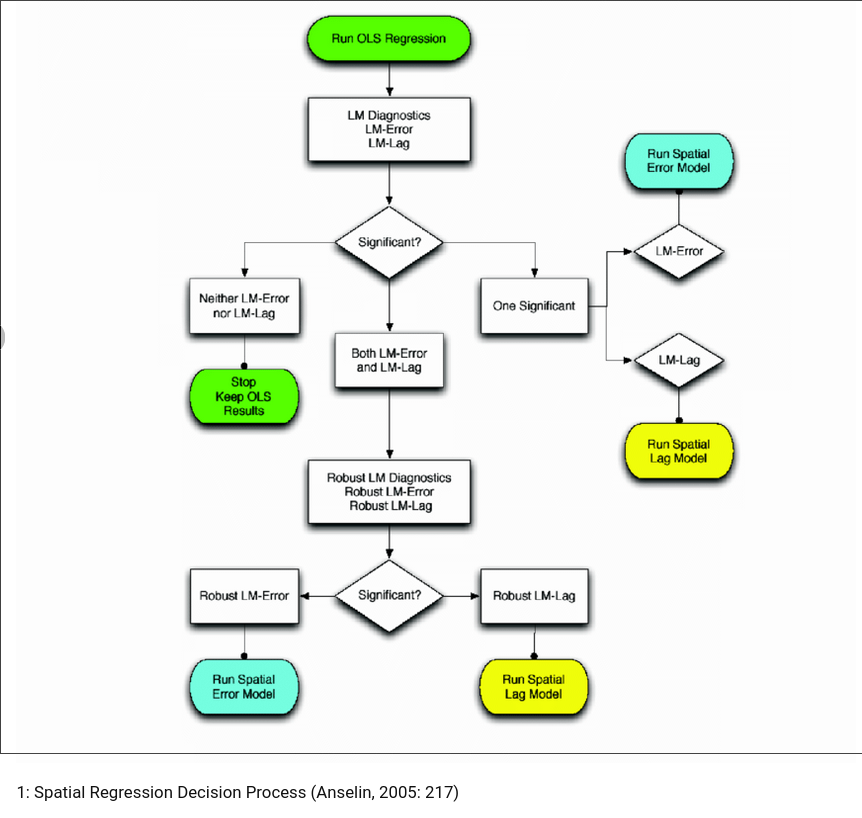

## Practice

At this point, it would be useful to set up your own baseline regression model, with a continuous dependent variable and at least two or three explanatory variables. You can pick any set of variables from the Chicago data set, from one of the GeoDa sample data sets or your own data, but of course, makes sure that your research question makes sense. Create some different types of spatial weights, such as contiguity and KNN weights for the Moran's I test.

Assess the extent to which your initial specification may suffer from some forms of misspecification, as well as the sensitivity of your results to different measures of standard errors.


# 4. IV/GMM Estimation of Spatial Models

This section we consider estimation of linear regression models based on instrumental variables (IV) and
the general method of moments (GMM). Models covered are the spatial lag model, the spatial error model, the spatial Durbin model, as well as the higher order models. Direct and indirect effects are illustrated as well. Models that include additional endogenous variables are briefly introduced.

Implementation of the GMM methods is included in a series of `PySAL-spreg` functions prefaced with `GM` and `GMM`, specifically `spreg.GM_Lag` and `spreg.GMM_error`. Beyond the classic lag and error models, additional specifications are set by means of the arguments `slx_lags` and `add_wy` for, respectively, spatially lagged regressors (WX) and a spatially lagged dependent variable (Wy).


We will illustrate the various regression models in the context of the *immigrant paradox* and use
four variables from the SDOH data set: **YPLL_rate** (an index measuring premature mortality, i.e., higher values are worse health outcomes), **HIS_ct** (economic hardship index), **Blk14P** (percent Black population), and **Hisp14P** 
(percent Hispanic population). In most specifications, we will treat the regressors as exogenous. We will illustrate the incorporation of additional endogenous variables by considering **HIS_ct** to be endogenous, with associated instruments **C_X** and **C_Y** (the census tract centroids).

We first create lists with the variable names for the dependent variable (y_name), the explanatory variables (x_names and xe_names), the endogenous variable (yend_names) and instruments (q_names), the data set (optional, as ds_name), the weights (optional, as w_name) and kernel weights (optional, as gwk_name). Note that the dependent variable needs to be a string, not a list with one element. On the other hand, the ds_name and w_name can be either a string or a list with one string element. The other variable names need to be specified as lists, even when there is only one, as is the case here for `yend_names`.

In [ ]:
y_name = 'YPLL_rate'
x_names = ['Blk14P','Hisp14P','HIS_ct']
xe_names = ['Blk14P','Hisp14P']
yend_names = ['HIS_ct']
q_names = ['C_X', 'C_Y']
ds_name = 'Chi-SDOH'
w_name = 'Chi-SDOH_q'

### Reading the Shape File

Since we are already very ar from the beginning of this notebook, let us review and reload the original data using the `read_file` command from *geopandas*.

In [ ]:
dfs = gpd.read_file(infileshp)
print(dfs.shape)
print(list(dfs))

Finally, just to make sure the indicator variable OBJECTID is integer, we explicitly set its type to integer. We may need this later for the weights manipulations.

In [ ]:
dfs = dfs.astype({'OBJECTID':'int'})

### Setting up the Variables

Note that we do not include a constant term in the x matrices. This is included by default in the `spreg` estimation routines.

In [ ]:
y = dfs[y_name].values.reshape(-1,1)
y.shape

In [ ]:
x = dfs[x_names].values
x.shape

In [ ]:
xe = dfs[xe_names].values
xe.shape

In [ ]:
yend = dfs[yend_names].values.reshape(-1,1)
yend.shape

In [ ]:
q = dfs[q_names].values
q.shape

### Reading the Spatial Weights

To keep life simple, we will read the weights from the files created with `GeoDa`. After reading the queen contiguity weights, we row-standardize them.

In [ ]:
wq = libpysal.io.open(infileq).read()
print(wq.n)
wq.transform = 'r'

## Spatial Lag Model


IV/GMM estimation of the spatial lag model is carried out by means of `spreg.GM_Lag`. This is a customized implementation of the two stage least squares estimation where the instruments for the spatially lagged dependent variable are computed internally. Additional endogenous variables can be specified as well.

The default setup requires the dependent variable, `y`, the explanatory variables, `x`, and the spatial weights `w`. The instruments are the first order spatially lagged explanatory variables, WX. They do not need to be specified separately. The order of spatial weights used as instruments is set by means of `w_lags` (the default is `w_lags = 1`).

The A-K test results for remaining error spatial autocorrelation are included by specifying `spat_diag=True` as one of the arguments.

As before, we will list the main results using the `summary` method.

### Exogenous Variables Only

In [ ]:
lag1 = spreg.GM_Lag(y,x,w=wq,spat_diag=True,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(lag1.summary)

The regression output follows the same format as for OLS, with the addition of the **Instrumented** or endogenous variables, in this case the spatially lagged dependent variable, and the **Instruments**, the spatially lagged regressors. Note that there are no likelihood-based measures of fit. Also, the R-squared is not a *real* R-squared, but the squared correlation between the predicted values and the observed dependent variable. There are two variants: the first is based on the *naive* predicted values (ignoring the endogeneity of Wy), the second on the use of the predicted value from the reduced form.

In this specification, the spatial autoregressive coefficient is 0.165, but not significant at 
p < 0.07. The A-K test does not suggest the presence of any remaining error spatial autocorrelation.

As was the case for OLS regression, the lag regression object `lag1` contains many attributes. Here, we will only use the `summary` method, but as before, predicted values, residuals and regression coefficients can be extracted as well.

The default IV estimation is to use only the first order spatially lagged explanatory variables as instruments. To have the second order included as well requires the option `w_lags=2`, which we will use in what follows.

### Heteroskedastic-Robust Standard Errors

The default result for the spatial lag model is to provide the classic estimators for standard errors. Heteroskedastic-robust standard errors are obtained in the usual fashion with the `robust="white"` option.

In [ ]:
lag2 = spreg.GM_Lag(y,x,w=wq,w_lags=2,robust="white",
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(lag2.summary)

Compared to the default results, the estimates are not affected, but the standard errors are.
Most importantly, the spatial autoregressive coefficient is no longer significant, with the standard errors roughly doubled and p=0.34.

### Exogenous and Endogenous Variables

To illustrate the inclusion of additional endogenous variables (beyond the spatially lagged dependent variable), we use the same `spreg.GM_Lag` command, but include `yend` for the endogenous variables and `q` for the associated instruments in the argument list. Optionally, `name_yend` and `name_q` can be specified as well. The proper matrix of exogenous regressors is `xe`. Everything else is the same as for the standard lag specification.

Note that the example here is purely to illustrate the functionality and should not be interpreted in substantive terms. 

In [ ]:
lag3 = spreg.GM_Lag(y,xe,yend=yend,q=q,w=wq,w_lags=2,
                   name_yend=yend_names,name_q=q_names,
                   name_y=y_name,name_x=xe_names,
                   name_w=w_name,name_ds=ds_name)
print(lag3.summary)

The main impact of including additional endogeneity is on the spatial autoregressive coefficient, which becomes essentially negligible. It remains to be seen whether the initial indication of a spatial lag effect was due to a real spatial process or instead due to ignoring endogeneity. In the current context, this is hard to establish.

In what follows, we will not consider this case, but it works the same everywhere. Additional endogenous variables are specified as `yend` with instruments `q`. These are the only necessary addition to the arguments.

Also, as in all cases, robust standard errors are obtained with `robust='white'` or `robust='hac'`.

### Multipliers

In models that include a spatially lagged dependent variable and/or spatially lagged explanatory variables, the
impact of a change in X on y is not simply the coefficient of X, as is the case in the standard regression model. Instead, the effect that results from changes in the neighboring values must also be accounted for. 

In Kim, Phipps and Anselin (2003), it was shown that if the change in the explanatory variable is uniform across observations, the *spatial multiplier* amounts to $1 / (1- \rho)$, with the total effect of a change in variable
$x_k$ amounting to $\beta_k / (1 - \rho)$. In our example, the spatial multiplier in the second spatial lag model (**lag2**) would be 
1.0 / (1.0 - 0.17663) = 1.215.

The Kim et al. approach then distinguished between the direct effect, i.e., the coefficient of the $\beta$ coefficients as estimated, and the total effect, which corresponds to this coefficient times the multiplier. An indirect effect is then the difference between the two.

LeSage and Pace (2009) introduce a slightly different set of concepts and use the terms average direct impact (ADI), average indirect impact (AII) and average total impact (ATI) as summaries computed from the matrix expression $(I - \rho W)^{-1}$ from the reduced form, $(I - \rho W)^{-1}X\beta$.

There is currently no functionality in official release of `spreg` for the computation of impacts. The direct, indirect and total impacts are simply the coefficients in the model multiplied by the respective multipliers.

### Kim, Phipps and Anselin (2003) Interpretation

The spatial multiplier, with the estimate for $\rho$ as the **last** element in the `betas` attribute, is easy to compute. It is also stored in thr regression object as the attribute `rho`.

In [ ]:
lag2.rho

In [ ]:
ati0 = 1.0 / (1 - lag2.rho)
print(ati0)

The direct, indirect and total effects:

In [ ]:
bdir0 = lag2.betas[1:-1]
print("Direct effect:\n", bdir0)
print("Total effect:\n", ati0*bdir0)
print("Indirect effect:\n", ati0*bdir0 - bdir0)

## Spatial Durbin Model

In essence, the Spatial Durbin model is a special case of a spatial lag model with spatially lagged regressors (WX) included. For the estimation of the spatial autoregressive coefficients, this means that the usual WX terms cannot be used as instruments, but higher order lags are needed, to avoid multicollinearity. This is handled internally.

The Spatial Durbin is specified by including the `slx_lags` term as one of the arguments. The default is `slx_lags = 1`, but higher orders are possible as well.

The other arguments are the same as for the standard `spreg.GM_Lag` command. The output listing indicates that the results are for a Spatial Durbin model.

In [ ]:
spdur = spreg.GM_Lag(y,x,w=wq,w_lags=2,slx_lags=1,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(spdur.summary)

The spatial autoregressive coefficient is much larger in absolute value than in the model without WX, but this may be an artifact. The coefficient estimate is not significant. Of the WX terms, only the one for W_Blk14P is significant and the coefficient of Hisp14P is no longer significant. The overall fit of the model barely increases.

Of note is that the coefficient for W_Blk14P is negative, whereas the coefficient for Blk14P was positive. This could point to a common factor constraint (i.e., the actual model is a spatial error model), but it does not hold for the other coefficients.

Note how the instruments are **W2_W_Blk14P** and **W_W_Blk14P**, etc., so they are the spatial lags of the spatially lagged regressors.

### SLX

For comparison purposes, we also run the Spatial Durbin model without the spatial lag term, i.e., a simple SLX specification. This does not require any special estimation method, but can be accomplished by passing the `slx_lags` argument to the `spreg.OLS` function. We also include the Moran's I test (as well as the other spatial diagnostics) with `spat_diag=True` and `moran=True`.

Again, the output listing indicates that the results pertain to an SLX model.

In [ ]:
slx = spreg.OLS(y,x,w=wq,slx_lags=1,
                   spat_diag=True,moran=True,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(slx.summary)

In contrast to the results for the Spatial Durbin model, in the simple SLX specification all the coefficients of the spatially lagged regressors are significant, but again the coefficient for Hisp14P is not. For Blk_14P and W_Blk_14P, the signs are opposite, suggesting a negative effect of the immediate neighbors, which is difficult to interpret (i.e., it does not make sense for this racial variable, given the high degree of positive spatial autocorrelation for the variable). For HIS_ct and W_HIS_ct, both coefficients are positive and significant, but the value for the spatial lag is *larger* than for the in-situ variable, which violates Tobler's law. Overall, the inclusion of the extra WX terms in the regression specification does not seem to be warranted in this instance.

Also, the Moran's I test only weakly suggests the presence of spatial autocorrelation.

## Spatial Error Model


As of version 1.4 of `spreg`, all spatial error estimation is implemented through the `GMM_Error` command. This is essentially a wrapper around the original implementations of the various `GM_Error`, `GM_Endog_Error` and `GM_Combo` functions (that still work exactly as before) with a more simplified interface.

Beyond the classic spatial error specification, more complex models can be estimated by including `slx_lags` (for additional WX) or `add_wy` (for inclusion of a spatially lagged dependent variable). This yields a range of higher order models, such as SLX Error, SARSAR (spatial lag with spatial errors), and the generalized nested specification (GNS), i.e., a Spatial Durbin model with spatial errors.

There are three implementations of the GMM estimation, specified through the `estimator` argument. The default is `estimator='het'`, which accounts for unspecified heteroskedasticity and provides asymptotic standard errors for the spatial autoregressive $\lambda$ coefficient. Its counterpart that does not account for heteroskedasticity is `estimator='hom'`. Finally, the legacy GM estimator initially suggested by Kelejian and Prucha (1998) and which does not provide any inference for the spatial parameter can be selected with `estimator='kp98'`.

Note that because the error variance is modeled explicitly, there are no `robust` options for the standard errors. They are obtained from the FGLS estimation.

In what follows, only the default `estimator='het'` case is illustrated, which is the most robust approach in practice.

Additional optional arguments that deal with techical details of the estimation are `max_iter` and `step1c` for the `het` case, and `max_iter` and `A1` for the `hom` case. Estimator `kp98` does not have these options. In the examples below, we use the default setting.

The minimum specification includes `y`, `x` and `w` for the weights as arguments. The output listing includes the specific method used.

In [ ]:
err1 = spreg.GMM_Error(y,x,w=wq,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(err1.summary)

In contrast to the results for the lag model, here the spatial autoregressive coefficient is highly significant, with p = 0.001. On the other hand, the significance of the Hisp14P coefficient is now p=0.02. The measure of fit is a pseudo R-squared, i.e., the squared correlation between observed and predicted values. Unlike what holds for the spatial lag model, there is only one predicted value, since there is no endogeneity of the spatial term.

However, there are two residual vectors. One is the simple residual, the difference $y - X\beta$, `u`, the other, `e_filtered` is $u - \lambda W u$, i.e., the residual with the spatial correlation removed. When testing the naive residuals for spatial autocorrelation, one may be surprised to find that it is not controlled for, but that is only the case for the spatially filtered residuals.

### Exogenous and Endogenous Variables

As in the spatial lag case, additional endogenous variables and associated instruments are added by including `yend` and `q` as arguments. Note that the regression matrix is now `xe`.

In [ ]:
err2 = spreg.GMM_Error(y,xe,w=wq,yend=yend,q=q,
                   name_yend=yend_names,name_q=q_names,
                   name_y=y_name,name_x=xe_names,
                   name_w=w_name,name_ds=ds_name)
print(err2.summary)

Accounting for endogeneity makes both the coefficient of HISP14P  and the coefficient of Blk14P insignificant. As mentioned, this is purely to illustrate the mechanics of the process, not a substantive interpretation.

## SLX Error Model

An SLX Error specification is obtained by including the argument `slx_lags=1`.

In [ ]:
err3 = spreg.GMM_Error(y,x,w=wq,slx_lags=1,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(err3.summary)

In this case, only the coefficient of W_HIS_ct is significant, but is is larger than that of HIS_ct, which again violates Tobler's law and is very difficult to interpret. On the other hand, the spatial autoregressive coefficient remains highly significant.

## SARSAR Model

To estimate the SARSAR model, the additional argument is `add_wy=True` with optionally `w_lags` to specify the order of the spatial lags to be used as the instruments.

In [ ]:
err4 = spreg.GMM_Error(y,x,w=wq,add_wy=True,w_lags=2,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(err4.summary)

In practice, the SARSAR model often yields counter-intuitive and contradictory results. In this instance, neither of the spatial coefficients is significant and they have opposite signs. On the other hand, the inference on the original regression variables is hardly affected.

## General 'Nested' Spatial Model - GNSM

Finally, the GNS model is fully loaded, with `slx_lags=1`, `add_wy=True` and optionally `w_lags`. It thus contains both a Spatial Durbin specification and a spatial autoregressive error term.

In [ ]:
err5 = spreg.GMM_Error(y,x,w=wq,slx_lags=1,add_wy=True,w_lags=2,
                   name_y=y_name,name_x=x_names,
                   name_w=w_name,name_ds=ds_name)
print(err5.summary)

The results are a bit overwhelming and counterintuitive. Both spatial autoregressive coefficients are highly significant (and very close to 1), but of opposite signs. That doesn't really make any sense. Also, again, the coefficient of Hisp14P turns insignificant and the signs of the WX coefficients are all negative. Since a spatial autoregressive error term is already included in the model, the common factor hypothesis is irrelevant. The negative signs are not compatible with the usual interpretation of spatial spillover.

In practice, the GNS model is rarely appropriate.

## Practice

The estimation methods illustrated here have many different options. Explore the sensitivity of the estimation results to some of these options and consider alternative specifications for the
base regression model using some additional variables from the data set or for your own model/data.

Alternatively, explore the effect of a different spatial weights matrix. Carefully consider the different specifications and what they mean for the interpretation of the *immigrant paradox*.

# 5. Spatial Regimes

This section we consider discrete heterogeneity in the form of spatial regimes, where the regimes have been specified exogenously. All the same specifications as before can be implemented in a regimes context, but we will focus only on the main ones: a standard regression (OLS), the spatial lag model with Spatial Durbin option, the spatial error model and an SLX model.

Implementation of the regimes estimation is included in a series of `PySAL-spreg` functions ending in `Regimes`, such as `spreg.OLS_Regimes` and `spreg.TSLS_Regimes` for non-spatial models. For spatial models with regimes, both GM and ML estimation is available, respectively in the `GM_Lag_Regimes` and `GMM_Error_Regimes`, as well as in `ML_Lag_Regimes` and `ML_Error_Regimes`.

We will also consider endogenous regimes as estimated through the `skater_reg` functionality. Instead of having the regimes specified beforehand, their optimal configuration is obtained by incorporating the least squares functionality in a Skater spatially constrained clustering algorithm.

### Setting up the Variables

We will continue to use
four variables from the SDOH data set: **YPLL_rate** (an index measuring premature mortality, i.e., higher values are worse health outcomes), **HIS_ct** (economic hardship index), **Blk14P** (percent Black population), and **Hisp14P** 
(percent Hispanic population). Note that we can include additional endogenous regressors in the spatial regimes models as well, although we will not consider that here. It works in the same way as for single regressions.

As before, we create lists with the variable names for the dependent variable (y_name), the explanatory variables (x_names), the data set (optional, as ds_name), and the weights (optional, as w_name)

In [ ]:
y_name = 'YPLL_rate'
x_names = ['Blk14P','Hisp14P','HIS_ct']
ds_name = 'Chi-SDOH'
w_name = 'Chi-SDOH_q'

In addition, we need to specify the regimes variable, here **regionno**. 

In [ ]:
rvar = 'regionno'

In [ ]:
y = dfs[y_name].values.reshape(-1,1)
y.shape

In [ ]:
x = dfs[x_names].values
x.shape

Currently, the regimes variable has to be a `list`, not a numpy array. We make sure this is the case by means of `tolist`.

In [ ]:
regimes = dfs[rvar].tolist()
type(regimes)

## Mapping the Regimes

A quick visualization of the spatial layout of the regimes, using the `plot` method for a spatial data frame. For the unique values
map depicting the variable `regionno`, we use `categorical=True` as the classification.

In [ ]:
dfs.plot('regionno',categorical=True,figsize=(6,6),legend=True)

## Standard Models

### OLS

We start with a classic OLS estimation, carried out by means of the `spreg.OLS_Regimes` function. All the arguments are the same as for a standard OLS regression, except for the addition of the `regimes` argument (the third *positional* argument) and its name, as `names_regimes`. In addition, we add a weights matrix and set `spat_diag = True` for spatial diagnostics. We get a listing of the results with the customary `summary` method.

The default treatment of the error term is to have a separate variance for each regime, i.e., groupwise heteroskedasticity. This is typically the most reasonable assumption in practice. For a constant error variance across all regimes, the option is `regime_err_sep = False`. We will not consider this here. Since the
default is `regime_err_sep = True`, we do not need to specify it in the list of arguments, but it is included here for the sake of clarity.

In [ ]:
reg1 = spreg.OLS_Regimes(y, x, regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(reg1.summary)

The results listing contains a lot of information. For each regime, the coefficient estimates and measures of fit are listed as if they were a separate regression. The order is the order of the regime categories, i.e., the Central, North, South and West regions. This is easy to verify by checking the number of observations listed for each regime. The measures of fit are computed for the subset of observations corresponding to the regime in question. For example, for the smallest subset, the Central region with 28 observations, the adjusted R2 is 0.532. This measure varies considerably across regimes, e.g., with values of 0.304 in North (273 observations), 0.474 for South (334 observations), and 0.709 for West (156 observations). This compares to the overall fit in the homogeneous model of 0.632.

The coefficient estimates and their significance vary considerably across regimes, highlighting the underlying spatial heterogeneity. The coefficient of Blk14P is highly significant and positive in the North, South and West, but not at all in the Central region. The coefficient of Hisp14P changes signs, from being negative and marginally significant (at respectively p < 0.04 and p < 0.02) in North and South, to being positive and highly significant in Central, and not significant in the West. Finally, economic hardship is always positive, but only strongly significant in North and South, marginally in Central (p < 0.03) and insignificant in the West (p < 0.07).

Each set of regime results also includes the customary regression diagnostics, including diagnostics for spatial effects with `spat_diag = True`, as is the case here. It should be noted that the spatial weights used for these diagnostics are *truncated*, in the sense that each regime becomes an island, without any connections to neighboring observations that are in a different regime. With that caveat in mind, we find little evidence for spatial dependence in the Central, South and West regimes, but strong evidence for lag dependence in the North.

Finally, at the bottom of the listing are some overall diagnostics. The Chow test for spatial heterogeneity indicates strong rejection of the null of homogeneity for the Hispanic coefficient, but none for economic hardship and weak evidence for the Blk14P coefficient. The overall test rejects the null at p < 0.02.

In addition, there is a global test for spatial effects, i.e., using the full set of residuals and spatial weights for all the observations. There is some weak evidence for an overall spatial lag alternative, but this is not supported by the robust test.

The individual attributes can be extracted in the usual fashion. An attribute specific to regimes regression is `multi`, a dictionary that contains the regression attributes for each regime separately.

In [ ]:
reg1.multi

Note how reg1.multi is a dictionary, with the regime labels as keys. Hence, to extract the regression information for the first regime, we use the notation multi[1] and not multi[0], since 1 is the key for the first regime. 

In [ ]:
print(dir(reg1.multi[1]))

### SLX

The regimes form for the SLX model is simply a special case of the OLS estimation, with the inclusion of `slx_lags=1`. The interpretation is the same as before.

In [ ]:
slx1 = spreg.OLS_Regimes(y, x, regimes, w=wq, spat_diag=True,
                        slx_lags=1,
                        regime_err_sep=True,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(slx1.summary)

The inclusion of the additional regressors is not very useful. Only W_HIS_ct is significant in the North and South regions, but none of the other spatially lagged explanatory variables are. The Global Chow tests rejects the null very strongly, at p < 0.01, supported by strong rejection for Hisp14P (p < 0.003) and Blk14P (p < 0.02), but not HIS_ct (p < 0.09). We will not consider this further.

## Regime Regression Options

The regimes regression has several other options that we do not illustrate here. In addition to the `regime_err_sep = False` already referred to, it is also possible to get heteroskedastic-robust standard errors, with `robust="white"`, or HAC standard errors, which we don't cover in this workshop. In addition, there is an option to implement multiprocessing with the `cores` option (this does not work on all platforms).

A more unique option is the possibility to combine fixed coefficients with varying coefficients in so-called hybrid specifications.

The combination of fixed and varying coefficients is implemented through the arguments `constant_regi` and `cols2regi`. The first manages the constant term, or intercept, the second deals with the slope coefficients.

The default setting for `constant_regi` is `many`, which allows the intercept to vary by regime. The default for `cols2regi` is `all`, which has all the slope coefficients varying by regime.

As a result, several combinations are possible, such as:

- global constant, varying slope coefficients

- global or varying constant, some slope coefficients varying, some not

- varying constant, slope coefficient fixed (i.e., fixed effects)


### Spatial Fixed Effects

An alternative specification only lets the constant vary by regimes, as so-called *spatial fixed effects*. This is achieved by setting `constant_regi = 'many'` with the list `colsvari = [False, False, False].

In [ ]:
colsvari = [False, False, False]

In [ ]:
reg2 = spreg.OLS_Regimes(y, x, regimes, w=wq, spat_diag=True,
                        regime_err_sep=True,
                        constant_regi='many',cols2regi=colsvari,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(reg2.summary)

The spatial fixed effects coefficients are all highly significant, but not sufficiently different for the Chow test to reject the null.

## Spatial Lag Model

The regimes specification for a spatial lag model can be estimated by means of IV/GMM with `spreg.GM_Lag_Regimes` or by means of maximum likelihood with `spreg.ML_Lag_Regimes`.

The arguments are the same as for the standard spatial lag model, with the addition of the `regimes` setting, and the regime-specific options discussed above. In the case of GMM estimation, additional endogenous variables may be included as well, with matching instruments. We do not consider this case here. As before, we set `w_lags=2`.

The default (highly recommended) is to have a *global* spatial autoregressive coefficient. If a separate autoregression is desired for each regime, the option `regime_lag_sep` is used. The default is `False`. It should be noted that the spatial weights used when a separate spatial model is specified of each regime are the *truncated* weights. This removes the connectivity structure between observations that belong to different regimes. This is typically not desired in practice, hence the default setting, although there may be situations where it is appropriate (e.g., for block-diagonal weights). We do not consider this further.

### IV/GMM Estimation

GMM estimation is implemented through `spreg.GM_Lag_Regimes`. The arguments are the same as for the
standard regression case, with the addition of the spatial weights `w` (and their name) and an option for
the number of spatial lags for the instruments, here `w_lags=2`.

The same hybrid specifications are allowed as for the standard models by means of the `constant_regi` and `cols2regi` arguments. This is no longer considered separately.

In the spatial models, there are two important options pertaining to the error variance and the spatial coefficient. Whereas in OLS estimation, the default is `regime_err_sep = True`, for groupwise heteroskedasticity, this is not the case for the spatial models. The default is to have a single spatial coefficients, i.e., `regime_lag_sep=False`, with `regime_err_sep=False`, but with `robust='white'` for robust standard errors.

For clarity, these arguments are specified explicitly, even though they are the defaults.

In [ ]:
lag1 = spreg.GM_Lag_Regimes(y, x, regimes, w=wq, w_lags=2,
                        regime_lag_sep=False,regime_err_sep=False,robust='white',
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(lag1.summary)

The coefficient listing has the global estimate for the spatial autoregressive coefficient at the bottom. 
The estimate of 0.251 is not significant. The regimes coefficient estimates are a little different from before: Blk14P is significant and positive in all regions except the first (Central); Hisp14P is only significant (and positive!) in the Central region; while HIS_ct is significant and positive everywhere except in the West.

The (spatial) Chow test again shows only weak evidence of heterogeneity, failing to reject the null for HIS_ct, and only weakly rejecting for the Global test (p < 0.05), Blk (p < 0.04) and Hisp14P (p < 0.03).

#### Separate Spatial Lag Models by Regime

It is possible to set `regime_lag_sep=True`, but then `regime_err_sep` also needs to be set to `True`, essentially resulting in a separate spatial regression by regime, with truncated spatial weights. If this is not the case, it will be done by the program and a warning will be included in the output listing. The default remains White standard errors, which can be changed by setting `robust=None` for simple groupwise heteroskedasticity.

In [ ]:
lag3 = spreg.GM_Lag_Regimes(y, x, regimes, w=wq, w_lags=2,
                        regime_lag_sep=True,robust=None,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(lag3.summary)

The separate spatial regressions provide strong evidence to reject the null of homogeneity for all variables except Blk14P. The overall test is also highly significant. The separate spatial autoregressive coefficient is only significant in regime 3. Note that this is based on truncated weights and therefore assumes that each regime is a spatial island, without any interaction with the other regimes.

## Spatial Durbin Model

The regimes specification for a Spatial Durbin model can be obtained as a special case of the spatial lag model with `slx_lags=1` (or higher) included as one of the arguments to either `GM_Lag_Regimes` or `ML_Lag_Regimes`. Since the inclusion of the WX terms in the SLX estimation above did not suggest any spatial effects, we do not pursue this further here.

## Spatial Error Model

The regimes specification for spatial error models can be estimated by means of both GMM or maximum likelihood. The corresponding commands are `GMM_Error_Regimes` and `ML_Error_Regimes`.

The default setting is to again have a single spatial coefficients with `regime_err_sep = False`. The `robust` options are irrelevant since heteroskedasticity can be accounted for in GMM through `estimator='het'` and is not supported in ML estimation.

### GMM Estimation

The regime-specific arguments to `GMM_Error_Regimes` are the same as above (allowing for hybrid models, etc.) and the other arguments are the same as for `GMM_Error`. The default `estimator='het'` for heteroskedastic-robust standard errors. We only show results for the default case. The other options can be examined in the usual way.

In [ ]:
err1 = spreg.GMM_Error_Regimes(y, x, regimes, w=wq, 
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(err1.summary)

The global spatial autoregressive coefficient is significant with a p-value less than 0.003. The Global Chow test is not significant, and there is only weak indication of heterogeneity for the Hisp14P coefficient (p < 0.03).

The other coefficients show the usual pattern. Blk14P is strongly significant and positive in all but the Central region; Hisp14P is only significant in the Central region, but positive; and HIS_ct is significant and positive in all regions, except for the West (p < 0.08).

## Other Error Models

As in the standard case, the SLX-Error model, the SARSAR model and the GNS model can be obtained by passing the proper combination of `slx_lags=1` and `add_wy=True` arguments to the `GMM_Error_Regimes` command. We do not further consider this.

## Practice

The functions considered here have many options. Assess the effect of these
options on the results and interpretation. For example, allow some regressors to vary while
keeping others fixed, check the impact of heteroskedasticity on the standard errors,
and/or vary the spatial weights. Which of the various specifications seems to make the
most sense in this example?

## Endogenous Regimes - Skater Regimes

The Skater-regimes approach proceeds in two steps. In the first, the optimal regimes allocation is obtained for a given number of regimes. More precisely, the optimization is carried out for all number of regimes up to the specified value of k.

In the second step, a *hard allocation* is applied to obtain the final regression coefficients. Even though regressions are used in the Skater optimization process, they are not available in the resulting Skater object.

To facilitate the optimization, the matrix of explanatory variables is first standardized. This is used to compute an initial *distance* matrix (in attribute space) from which the minimum spanning tree is obtained. The remainder of the algorithm is based on the regression results using the original (unstandardized) x matrix.

In [ ]:
x_std = (x - np.mean(x,axis=0)) / np.std(x,axis=0)

### Optimization Step

The command to compute the Skater regimes (regions) is `spreg.skater_reg.Skater_reg`, followed by a `fit` method. This follows Python convention (e.g., in scikit-learn) where first an object is created (or a class), to which then specific methods can be applied or attributes extracted. In practice, the two steps are combined, as illustrated below. The particular structure follows from the implementation of the Skater algorithm in PySAL's `spopt` package, from which skater-reg is derived.

The arguments to the `fit` method are the number of regimes (here 4), followed by the spatial weights and the matrix used to compute the initial distance matrix, here `x_std`. The fourth argument is a dictionary, with keys `reg`, `y`, and `x`, respectively for the type of regression (both OLS and GM_Lag are currently supported), the dependent variable and the matrix of explanatory variables (a constant term is assumed and should not be included). Note that the matrix of explanatory variables is in the original scale, and is *not* the standardized matrix used for the distance calculations. A final argument is the minimum size for each region, i.e., the minimum number of observations required for regime estimation, as `quorum`. In our example, `quorum = 100`. 

Depending on the total number of observations and the maximum number of regimes considered, the quorum may lead to the lack of a solution. Because of the nature of the Skater algorithm, any subsequent *cut* in the minimum spanning tree leads to a smaller subregion. When such a subregion fails to meet the `quorum` minimum size, the algorithm stops and fails to reach the required number of regimes.

In our example, we create the skater object `endr1`. Note that this class (currently) does not have a `summary` method. The command `spreg.skater_reg.Skater_reg( )` initializes the skater class. The method `fit` computes the regimes allocation.

In [ ]:
endr1 = spreg.skater_reg.Skater_reg().fit(4, wq, x_std, {'reg':spreg.OLS,'y':y,'x':x}, quorum=100)

The resulting object is very complex, as illustrated by a `dir` command.

In [ ]:
print(dir(endr1))

For our purposes, the most important attribute is the `_trace`, a list of lists which contains for each *cut* a vector (numpy array) with the resulting region labels and the information on in and out node, as well as the value for the overall objective function. The list contains k=4 elements, but the first one is empty.

In [ ]:
len(endr1._trace)

In [ ]:
endr1._trace[0]

The full list has the results for k=2, 3 and 4 in positions 1, 2, and 3.

In [ ]:
endr1._trace

For k=4, the results are in position 3. The first item is a numpy array with the regime labels, going from 0 to 3. Listing the first few items:

In [ ]:
endr1._trace[3][0][0:10]

The second element of the list in position 3 is itself a list with the `in_node`, the `out_node`, and, more importantly, the value for the objective function, the `score`. We extract the score as item `[3][1][2]`:

In [ ]:
endr1._trace[3][1][2]

## Hard Allocation

The first Skater optimization step is followed by a standard regimes regression using the solution as a *hard allocation* to regimes.

The final regime classification obtained by the Skater algorithm is contained in the vector in position `[3][0]`. In order to keep consistency with the regime labels used before, we add 1 to the classification, so that it now ranges from 1 to 4. We store the result in the `regimes` variable.

In [ ]:
regimes = endr1._trace[3][0] + 1
regimes[0:10]

### Regimes plot

In order to make a map of the regimes, we need to add a new variable to the spatial data frame `dfs`. We call the variable `sk_regions` and use the `plot` method to create a simple unique values map, with the regime regions labeled 1 through 4.

In [ ]:
dfs["sk_regions"] = regimes
dfs.plot('sk_regions', categorical=True, figsize= (7,7), legend=True, cmap='Paired')

### Regime Regression

We can now also carry out the regimes regression using `OLS_Regimes` with the `regimes` result.

In [ ]:
reg1 = spreg.OLS_Regimes(y, x, regimes, w=wq, spat_diag=True,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(reg1.summary)

The results are quite different from the exogenous regimes exercise we carried out previously. While the Global test strongly rejects the null of homogeneity (p < 0.0000), for the individual coefficients, this is only the case for `HIS_ct`. The latter is positive and highly significant in regimes 2 and 3, but not in 1 and 4. `Blk14P` is highly significant and positive in all regimes, but without sufficient evidence to reject the null of homogeneity. `Hisp14P` is not significant in any of the regimes.

## Optimal Number of Regimes

So far, we have used the same number of regimes as in the exogenous case. However, `Skater_reg` computes all the allocations up to the given value of k, which allows for the construction of a so-called *elbow function*. The latter shows the evolution of the overall measure of fit with a change in number of regimes. As the number of regimes increases, the fit is always better, but at some point, the improvement is no longer substantial, suggesting a *break* in the plot. This indicates the optimal number of regimes. In practice, detecting a break is not always that easy, as illustrated below.

We will now run the Skater algorithm for all regime allocations up to k=15. In order to obtain feasible solutions, we have to lower the `quorum` to 30. For a higher number of regimes, the quorum has to be made even smaller, which does no longer allow for meaningful regression results in the smallest regimes.

The command is the same as before, but now with `15` as the number of regimes, and `quorum=30`.

In [ ]:
endropt = spreg.skater_reg.Skater_reg().fit(15, wq, x_std, {'reg':spreg.OLS,'y':y,'x':x}, quorum=30)

We can now extract the value for the objective function, the score from each item in the `_trace` attribute. We create a list with those values as trace. 

In [ ]:
trace = [endropt._trace[i][1][2] for i in range(1,len(endropt._trace))]
print(trace)

The first value is the score for k=2, next for k=3, etc. We see how the value *decreases* from 2,780,615,032 to 2,251,989,467 for k=15. This is visualized by means of an elbow plot.

### Elbow Plot

The elbow plot is a simple line graph of the value of the score against k. We create a list for k to be used for the x-axis.

In [ ]:
kvalues = np.arange(2,len(endropt._trace)+1)
kvalues

We now use the seaborn `sns.lineplot` function to graph the sum of squared residuals on the number of regimes. First, we use `set_themes` to have a nice grid background (totally optional, of course). The `lineplot` command itself, just requires the `x` and `y` arguments. Since these are lists in our example, we do not need to specify a data frame. To spiff up the graph, we place dots at the actual values and set labels for the x and y axes.

In [ ]:
ax = (pd.DataFrame({'Number of Regimes': kvalues, 'Sum of Squared Residuals': trace})
      .plot(x='Number of Regimes', y='Sum of Squared Residuals', marker='o'))

The result suggests a possible break at 7. Consequently, we extract the regime classification from position `6`. As before, we add 1 to the result to retain compatible labels. The result is stored in the new regimes variable `regimes1`.

In [ ]:
regimes1 = endropt._trace[6][0] + 1

### Optimal Regimes Map

We can now add the new regimes variable to our spatial data frame as `opt_regions` and use the `plot` method to obtain a unique values map. We reset the `style` to `white` to get rid of the grid lines.

In [ ]:
dfs["opt_regions"] = regimes1
dfs.plot('opt_regions', categorical=True, figsize=(7,7),legend=True, cmap='Paired')

### Optimal Regimes Regression

Finally, we obtain the regimes regression using `OLS_Regimes` with `regimes1` as the new regimes variable.

In [ ]:
regopt = spreg.OLS_Regimes(y, x, regimes1, w=wq, spat_diag=True,
                        name_y=y_name, name_x=x_names, name_regimes=rvar,
                        name_w=w_name,name_ds=ds_name)
print(regopt.summary)

The size of the resulting regimes varies from 33 for regime 3 to 210 for regimes 1 and 5. The regimes diagnostics provide strong evidence for heterogeneity. The Global test is significant at p = 0.0000, and the null is strongly rejected for both `Blk14P` (p < 0.0006) and `Hisp14P` (p < 0.0042), and weakly so for `HIS_ct` (p < 0.0273). The individual regression results vary considerably as well, with adjusted R2 ranging from a low 0.0284 in regime 4, to 0.6193 in regime 3. A further substantive interpretation of the coefficient variation is beyond our scope.

## Practice

Consider the optimal regimes allocation for different spatial weights, i.e., other than queen contiguity. Also assess the extent to which the results are affected by including the dependent variable in the calculation of the original distance matrix (i.e., not only standardized x, but also standardized y), a practice that is sometimes employed to find data-driven spatial regimes.

# 6. Spatial Panels Using SUR 

Up to this point, we have considered only estimators and tests limited to cross-sectional analysis. In this section we consider specifications for which observations are available in two dimensions: space and time. The Seemingly Unrelated Regression (SUR) models take into account a limited degree of simultaneity in the form of dependence between the error in different equations. As stated in Anselin (1988), if the equations pertain to time series for different regions, the resulting dependence can be considered as a form of spatial autocorrelation. 

Most of the same specifications as before can be implemented in a SUR context, but we will focus only on the main ones: a standard regression (OLS), the spatial lag model, and the spatial error model. 

Implementation of the SUR models is included in a series of `PySAL-spreg` functions, such as `spreg.SUR` and `spreg.ThreeSLS` for non-spatial models. For spatial models, both GM and ML estimation is available, in the `SURlagIV`, as well as in `SUR_errorGM` and `SUR_errorML`.

### Files

We will be using data on homicides and selected socio-economic characteristics for continental U.S. counties. Data for four decennial census years: 1960, 1970, 1980 and 1990:

- **NAT.shp,shx,dbf,prj**: homicides and selected socio-economic characteristics for 3,085 continental U.S. counties

You can find more info on the data here: https://geodacenter.github.io/data-and-lab/ncovr/



In [ ]:
folder = "data/NAT/"
infileshp = folder+"NAT.shp"   # input shape file
outfileshp = folder+"out_NAT.shp" # output shape file

We will read the shapefile the same way as before, using the function `read_file`, followed by the file pathname in parentheses.

In [ ]:
dfs = gpd.read_file(infileshp)
print(dfs.shape)
dfs.head()

Since there are too many observations in the data (think 4 times periods * 3,085 counties), we will select only the counties in southern states to simplify our applications on this workshop. We will also select only the variables we are interested in. Feel free to run the examples using the full data.

In [ ]:
dfs2 = dfs[dfs['SOUTH'] == 1]
dfs2 = dfs2[['FIPSNO','HR80','HR90','PS80','PS90','UE80','UE90','RD80','RD90','geometry']]
print(dfs2.shape)

In [ ]:
dfs2.plot('HR90', figsize=(6, 6),cmap='OrRd',scheme='quantiles',k=4,legend=True,
       legend_kwds={'loc':'center left','bbox_to_anchor':(1,0.5)})

The resulting shapefile can be exported using `Geopandas`:

In [ ]:
dfs2.to_file(outfileshp)

### Queen Contiguity Weights

The weights can be constructed the same way as before using `libpysal` package in PySAL. The function is `weights.Queen.from_dataframe` with as arguments the geodataframe and optionally the `ids` (recommended).

In [ ]:
wq1 = libpysal.weights.Queen.from_dataframe(dfs2,ids='FIPSNO')
wq1.transform = 'r'
wq1

In [ ]:
wq1.n

### Setting up the Variables

The specification of the model to be estimated can be provided as lists. Each equation should be listed separately. In this example, equation 1 has HR80 as dependent variable and PS80 and UE80 as exogenous regressors. For equation 2, HR90 is the dependent variable, and PS90 and UE90 are the exogenous regressors.

In [ ]:
y_var = ['HR80','HR90']
x_var = [['RD80','PS80','UE80'],['RD90','PS90','UE90']]

The SUR method requires data to be provided as dictionaries. `PySAL-spreg` provides the tool `sur_dictxy` to create these dictionaries from the list of variables. The line below will create four dictionaries containing respectively the dependent variables (bigy), the regressors (bigX), the dependent variables' names (bigyvars) and regressors' names (bigXvars). 

The data should be read using `PySAL`'s io format to match the format expected by `sur_dictxy`, as below

In [ ]:
db_pysal = libpysal.io.open(folder+"out_NAT.dbf",'r')
bigy,bigX,bigyvars,bigXvars = spreg.sur_dictxy(db_pysal,y_var,x_var)

The SUR format stores each equation separatly in a dictionary:

In [ ]:
bigy.keys()

In [ ]:
print("Y:", bigy[0].shape, "X:", bigX[0].shape, "Y_name:",bigyvars[0], "X_names:",bigXvars[0])

## Non-spatial models

For exogenous regressors only, we can use the function `SUR` to estimate the model and assess spatial diagnostics.

In [ ]:
reg1 = spreg.SUR(bigy,bigX,w=wq1,name_bigy=bigyvars,name_bigX=bigXvars,
                 spat_diag=True,name_ds="out_NAT.dbf",name_w="Queen_1")
print(reg1.summary)

The main interest in the classic spatial SUR model is to assess the extent to which the crossequation covariances (or, equivalently, correlations) are signiﬁcantly diﬀerent from zero. If that is not the case, then there is no gain in eﬃciency from a SUR approach over separate equation-by-equation regressions. The two most commonly used tests in this context are based on the Likelihood Ratio (LR) and the Lagrange Multiplier (LM) principle (for technical details, see again, e.g., Greene, 2012). In this example, both test statistics are significant, suggesting that the SUR approach is more efficient than separate estimations.

From the Chow test between equations, we can see that the coefficients for the different time periods are significantly different for the variables RD and UE, with p-values < 1%. Only the coefficients for UE and the constants are not significantly different across equations.

The spatial diagnostics reject the null hypothesis of spatial randomness for both error and lag alternatives. Since both statistics have similar values, we can run the two different specifications and compare the models’ fit.

## Spatial SUR models

### Spatial Lag

Let's start with a spatial lag specification since the omission of a relevant spatial lag would render the estimated coefficients inconsistent. We can use the function `SURlagIV`. 

In [ ]:
reg_lag = spreg.SURlagIV(bigy,bigX,w=wq1,name_bigy=bigyvars,name_bigX=bigXvars,
                               name_ds="NAT",name_w="Queen_1")
print(reg_lag.summary)

The results from this model suggest that the spatial lag is significant only for the data from the year 1990, since the p-value for W_HR90 is smaller than 5%. For 1980, the z-statistic of the spatial lag does not reject the null hypothesis. Keep in mind that albeit not significant for the first equation, the spatial lag remains as part of the specification, so it should either be removed from that equation or the coefficients must be interpreted considering the spatial multiplier effect.

Alternatively, to estimate a spatial error model, we can either use the function `SURerrorGM` or `SURerrorML`. Note that neither of these functions provides inference on the spatial autoregressive coefficient `lambda`, which can be simulated using an empirical distribution and bootstrapping techniques. 

In [ ]:
reg_error = spreg.SURerrorGM(bigy,bigX,w=wq1,name_bigy=bigyvars,name_bigX=bigXvars,
                               name_ds="NAT",name_w="Queen_1")
print(reg_error.summary)

# 7. Probit Models 

Up to this point, we have considered only estimators and tests for continuous dependent variables. In this section  we turn to diagnostic test for spatial autocorrelation in the probit model.

This functionality is contained in the `spreg.Probit` class. There are other ways to estimate probit models in Python, such as in the `statsmodels` module, but these implementations do not include the spatial diagnostics.

For the sake of convenience, the estimation of a probit model as well as the diagnostics are both included.
Specifically, the probit test by Pinkse and Slade (1998), Pinkse (1998), and Kelejian and Prucha (2001) are implemented. These are all based on slightly different forms of generalized residuals.

The data set used is the so-called **Katrina** data set, used as an empirical illustration in a paper
by LeSage et al (2011). This is included as a sample data set in the `R` `ProbitSpatial` and `spatialprobit` packages. The original data have been edited to add UTM Zone 15N projected coordinates (in addition to the original lat-lon), a unique identifier (ID), and a constant term (const). It is available as both a shape file and a csv file. We will use the latter. The variable names have been slightly adjusted to work as a shape file in `GeoDa`.

Note that the Katrina data set consists of three separate near-linear street segments. This will cause some problems with contiguity-based spatial weights. Therefore, nearest-neighbor weights are used in this illustration.

### Files

We will use the Katrina data file and two (symmetric) k-nearest neighbor weights files created in `GeoDa` with k=11 (the one used by LeSage et al 2011). The following files should be in the working directory:

- **Katrina_utm.csv**: data on store reopenings after hurricane Katrina on three street segments in New Orleans
- **Katrina_utm_k11s.gal**: symmetric k-nearest neighbor weights for k=11

## Read in Data and Weights Files

The data are read in from the **Katrina_utm.csv** file using the pandas `read_csv` functionality:

In [ ]:
folder = "data/Katrina/"
df = pd.read_csv(folder+"Katrina_utm.csv")
print(df.shape)
df.head()

The two weights are read from the gal file and row-standardized. Finally, a quick check on the contents. Ignore the warning.

In [ ]:
wk11 = libpysal.io.open(folder+"Katrina_utm_k11s.gal").read()
wk11.transform = 'r'
wk11.n
wk11.weights['1']

## Model Specification

The basic model specification uses the same variables as in LeSage et al (2011). The dependent variable is `y1`, whether or not a store has re-opened within three months of the hurricane. The explanatory variables are:
- `flood_dpth`: depth of flooding
- `log_medinc`: log of median income
- `small_size`: dummy for small size (medium is reference)
- `large_size`: dummy for large size (medium is reference)
- `low_cust`: low status customers dummy
- `high_cust`: high status customers dummy
- `sole_prop`: sole proprietorship dummy
- `nat_chain`: national chain dummy

As in the previous notebooks, we first create lists with the variable names for the dependent variable (y_name), the explanatory variables (x_names), the data set (optional, as ds_name) and the weights (optional, as w_name).


In [ ]:
y_name = 'y1'
x_names = ['flood_dpth','log_medinc','small_size','large_size','low_cust','high_cust',
           'sole_prop','nat_chain']
ds_name = 'Katrina_utm'

In *spreg*, the dependent and explanatory variables need to be passed, respectively as a numpy matrix of dimension nx1 and as a numpy matrix of dimension nxk (with k as the number of explanatory variables, not including the constant term).

This is a two-step process: first the variables are pulled from the pandas data frame using the bracket notation, subsequently this data frame is turned into a numpy array. We carry out a quick check on the dimension using `shape`.

In [ ]:
y = df[y_name].values.reshape(-1,1)
y.shape

In [ ]:
x = df[x_names].values
x.shape

## Linear Regression

We start with a linear regression, just as a quick check.

In [ ]:
reg1 = spreg.OLS(y,x,name_y=y_name,name_x=x_names,name_ds=ds_name)
print(reg1.summary)

The fit is rather poor (not a surprise, since it is a linear approximation to a non-linear function),
with an adjusted $R^2$ of 0.28. The `flood_dpth` variable is strongly significant (p=0.0000) and negative, whereas
`log_medinc` is positive and strongly significant (p=0.000001). In addition low status customers are also significant and
negative (p=0.003), and sole proprietorship is slightly significant and positive (p=0.011). The other variables are not significant in a linear regression.

## Probit Regression

First, we run the probit regression without diagnostics. The arguments are largely the same as for OLS regression, except that there is also an argument `optim` (default is `newton`, alternatives are `ncg` and `bfgs` -- see the docs for details), and `scalem`, the method to calculate the scale of the marginal effects (default is `phimean`).

For our example, this gives:

In [ ]:
pb1 = spreg.Probit(y,x,optim='bfgs',w=wk11,spat_diag=True,
                   name_y=y_name,name_x=x_names,name_ds=ds_name)
print(pb1.summary)

In addition to the four significant variables identified in the linear regression, the probit regression now also includes `small_size` as weakly significant (p=0.05) and negative. The signs of the significant variables are the same as in the linear regression, but now sole propietorship is significant at p=0.004. The output also lists some measures of fit, which are not relevant in our current context (they would be if we compared different probit specifications).

All three spatial diagnostics strongly reject the null of no error spatial autocorrelation. Note that the result for the Kelejian-Prucha test is the standard normal form, so 2.896 is the value of a z-statistic, not a Chi-squared statistic as for the other two diagnostics. Overall, there is rather strong evidence that including the explanatory variables has not removed
the spatial autocorrelation.

`Spreg` does not provide functions to estimate spatial lag or spatial error Probit models, but we can reassess the spatial dependence in a SLX specification by adding spatial lags of the regressors. For the Probit function, these lags must be calculated before the function is called:

In [ ]:
slx = libpysal.weights.lag_spatial(wk11, x)
x_slx = np.hstack((x,slx))
x_names2 = x_names + ['W_' + item for item in x_names]

In [ ]:
pb_slx = spreg.Probit(y,x_slx,optim='bfgs',w=wk11,spat_diag=True,
                   name_y=y_name,name_x=x_names2,name_ds=ds_name)
print(pb_slx.summary)

From the results above, we can see that including the spatial lagged regressors resulted in no remaining spatial autocorrelation in the residuals. Hence, the classic spatial probit estimator with spatial lagged regressors is the correct estimator for this specification and there is no need to estimate a spatial lag probit model or spatial error probit model.

## Practice

Consider the extent of spatial autocorrelation using the other two dependent variables, `y2` (re-opening after 6 months), and `y3` (re-opening after 12 months). Alternatively, create additional spatial weights for different numbers of nearest neighbors (make sure the weights are symmetric) and assess the sensitivity of the result to different neighbor specifications.